In [2]:
# Synthetic dataset creation code
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification

# Generate synthetic data
# 1000 samples, 20 features, 2 informative, 2 redundant, binary classification
X, y = make_classification(
    n_samples=1000,  # Number of samples
    n_features=20,   # Number of features
    n_informative=2, # Number of informative features
    n_redundant=2,   # Number of redundant features
    n_clusters_per_class=1,
    weights=[0.5, 0.5], # Equal distribution of classes
    flip_y=0.01,     # Small noise
    random_state=42
)

# Convert to DataFrame
feature_columns = [f'feature_{i}' for i in range(X.shape[1])]
data = pd.DataFrame(X, columns=feature_columns)
data['label'] = y  # Add the target column

# Save the dataset to a CSV file
data.to_csv('autism_data.csv', index=False)

print("Dataset created and saved as 'autism_data.csv'.")


Dataset created and saved as 'autism_data.csv'.


Training model 1/5...
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7911 - loss: 0.4592
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9230 - loss: 0.2211
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9376 - loss: 0.1458
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9489 - loss: 0.1322
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9489 - loss: 0.1169
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9323 - loss: 0.1458
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9571 - loss: 0.1075
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9532 - loss: 0.1052
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9667 - loss: 0.0815
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9816 - loss: 0.0599
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9715 - loss: 0.0819
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9755 - lo

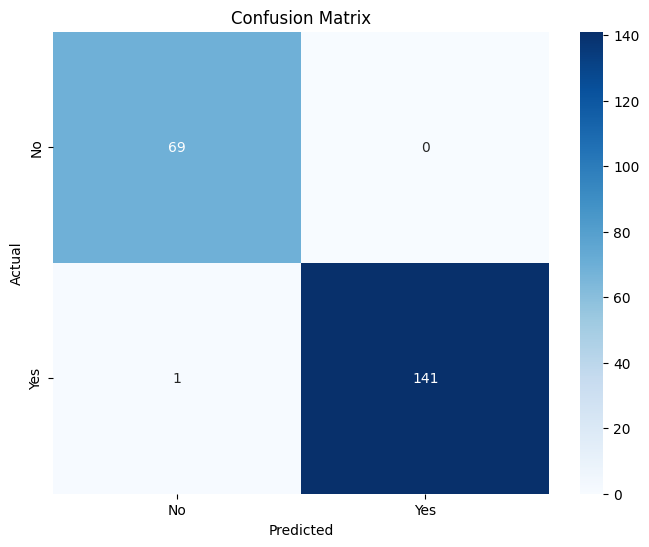

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import Adam
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = "/content/Toddler Autism dataset July 2018.csv"
data = pd.read_csv(file_path)

# Correcting the column name by stripping extra spaces
data.rename(columns=lambda x: x.strip(), inplace=True)

# Convert target variable to binary (1 for 'Yes', 0 for 'No')
data['label'] = data['Class/ASD Traits'].apply(lambda x: 1 if x == 'Yes' else 0)

# Drop irrelevant columns
data = data.drop(['Case_No', 'Class/ASD Traits'], axis=1)

# One-hot encode categorical variables
categorical_columns = ['Sex', 'Ethnicity', 'Jaundice', 'Family_mem_with_ASD', 'Who completed the test']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Split the features and target
X = data.drop('label', axis=1)
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Function to build a neural network model
def build_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# Number of models to use in the ensemble
num_models = 5
ensemble_models = []

# Train the ensemble models
for i in range(num_models):
    print(f"Training model {i+1}/{num_models}...")
    model = build_model()
    model.fit(X_train, y_train, epochs=100, batch_size=9, verbose=1)
    ensemble_models.append(model)

# Function to make ensemble predictions
def ensemble_predict(X):
    # Get predictions from all models
    predictions = np.zeros((X.shape[0], num_models))
    for i, model in enumerate(ensemble_models):
        predictions[:, i] = model.predict(X).flatten()

    # Average the predictions across all models
    averaged_predictions = np.mean(predictions, axis=1)

    # Convert probabilities to binary predictions (0 or 1) based on 0.5 threshold
    return [1 if p >= 0.5 else 0 for p in averaged_predictions]

# Evaluate the ensemble model
ensemble_predictions = ensemble_predict(X_test)

# Calculate accuracy
accuracy = np.mean(np.array(ensemble_predictions) == y_test)
print(f'Ensemble Accuracy: {accuracy * 100:.2f}%')

# Generate confusion matrix
cm = confusion_matrix(y_test, ensemble_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


Training model 1/5...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8237 - loss: 0.4424
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9468 - loss: 0.1730
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9485 - loss: 0.1431
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9318 - loss: 0.1527
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9492 - loss: 0.1173
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9549 - loss: 0.1009
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9591 - loss: 0.1033
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9713 - loss: 0.0873
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9638 - loss: 0.1029
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9621 - loss: 0.0946
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9817 - loss: 0.0575
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

Model 1 saved as ensemble_models/model_1.h5
Model 2 saved as ensemble_models/model_2.h5


Model 3 saved as ensemble_models/model_3.h5


Model 4 saved as ensemble_models/model_4.h5
Model 5 saved as ensemble_models/model_5.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Ensemble Accuracy: 99.53%


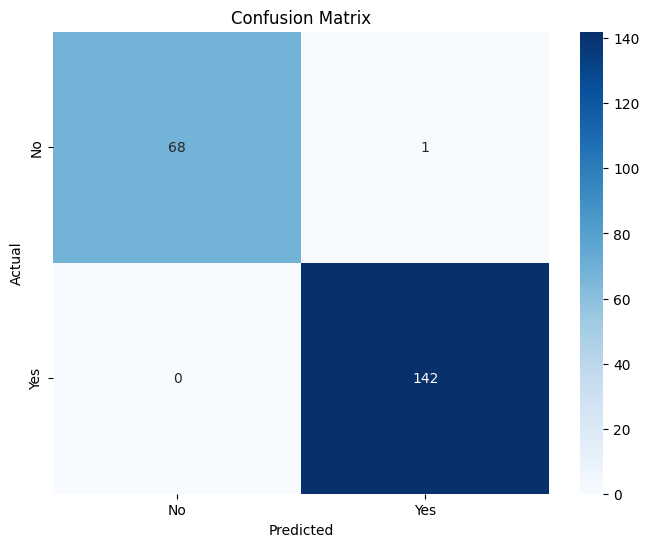

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import Adam
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model
import os

# Load the dataset
file_path = "./archive(1)/Toddler Autism dataset July 2018.csv"
data = pd.read_csv(file_path)

# Correcting the column name by stripping extra spaces
data.rename(columns=lambda x: x.strip(), inplace=True)

# Convert target variable to binary (1 for 'Yes', 0 for 'No')
data['label'] = data['Class/ASD Traits'].apply(lambda x: 1 if x == 'Yes' else 0)

# Drop irrelevant columns
data = data.drop(['Case_No', 'Class/ASD Traits'], axis=1)

# One-hot encode categorical variables
categorical_columns = ['Sex', 'Ethnicity', 'Jaundice', 'Family_mem_with_ASD', 'Who completed the test']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Split the features and target
X = data.drop('label', axis=1)
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Function to build a neural network model
def build_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# Function to save the models
def save_models(models, directory='ensemble_models'):
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i, model in enumerate(models):
        model.save(os.path.join(directory, f'model_{i + 1}.h5'))
        print(f'Model {i + 1} saved as {directory}/model_{i + 1}.h5')

# Number of models to use in the ensemble
num_models = 5
ensemble_models = []

# Train the ensemble models
for i in range(num_models):
    print(f"Training model {i + 1}/{num_models}...")
    model = build_model()
    model.fit(X_train, y_train, epochs=100, batch_size=9, verbose=1)
    ensemble_models.append(model)

# Save the trained ensemble models
save_models(ensemble_models)

# Function to make ensemble predictions
def ensemble_predict(X):
    # Get predictions from all models
    predictions = np.zeros((X.shape[0], num_models))
    for i, model in enumerate(ensemble_models):
        predictions[:, i] = model.predict(X).flatten()

    # Average the predictions across all models
    averaged_predictions = np.mean(predictions, axis=1)

    # Convert probabilities to binary predictions (0 or 1) based on 0.5 threshold
    return [1 if p >= 0.5 else 0 for p in averaged_predictions]

# Evaluate the ensemble model
ensemble_predictions = ensemble_predict(X_test)

# Calculate accuracy
accuracy = np.mean(np.array(ensemble_predictions) == y_test)
print(f'Ensemble Accuracy: {accuracy * 100:.2f}%')

# Generate confusion matrix
cm = confusion_matrix(y_test, ensemble_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load the dataset
file_path = "./archive(1)/Toddler Autism dataset July 2018.csv"
data = pd.read_csv(file_path)

# Correcting the column name by stripping extra spaces
data.rename(columns=lambda x: x.strip(), inplace=True)

# Convert target variable to binary (1 for 'Yes', 0 for 'No')
data['label'] = data['Class/ASD Traits'].apply(lambda x: 1 if x == 'Yes' else 0)

# Drop irrelevant columns
data = data.drop(['Case_No', 'Class/ASD Traits'], axis=1)

# One-hot encode categorical variables
categorical_columns = ['Sex', 'Ethnicity', 'Jaundice', 'Family_mem_with_ASD', 'Who completed the test']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Split the features and target
X = data.drop('label', axis=1)
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Function to load models from directory
def load_ensemble_models(directory='./ensemble_models'):
    models = []
    for i in range(1, 6):  # Assumes 5 models saved as model_1.h5, model_2.h5, ..., model_5.h5
        model_path = os.path.join(directory, f'model_{i}.h5')
        model = load_model(model_path)
        models.append(model)
        print(f'Model {i} loaded from {model_path}')
    return models

# Function to make ensemble predictions
def ensemble_predict(models, X):
    num_models = len(models)
    predictions = np.zeros((X.shape[0], num_models))
    
    for i, model in enumerate(models):
        predictions[:, i] = model.predict(X).flatten()
    
    averaged_predictions = np.mean(predictions, axis=1)
    return [1 if p >= 0.5 else 0 for p in averaged_predictions]

# Load the saved ensemble models
ensemble_models = load_ensemble_models()

# Evaluate the ensemble model
ensemble_predictions = ensemble_predict(ensemble_models, X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, ensemble_predictions)
precision = precision_score(y_test, ensemble_predictions)
recall = recall_score(y_test, ensemble_predictions)
f1 = f1_score(y_test, ensemble_predictions)

# Print the evaluation metrics
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1-Score: {f1 * 100:.2f}%')

# Generate confusion matrix
cm = confusion_matrix(y_test, ensemble_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
